# Remove the Background from Images
The Computer Vision API 4.0 can be used to generate an image from a source file with the background removed (transparent area in png. output file). Optionally a foreground matte image can also be generated. It is a grayscale image used to determine the transparency of different parts of an image or video. It helps isolate a subject (the foreground) from the background, allowing the subject to be placed onto a new background. This technique is widely used in film production, photography, and image editing.

<img src="../media/background-removal.png" alt="drawing" style="width:1200px;"/>

Prerequisites:
- An Azure Computer Vision resource. Consult the [documentation](https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/quickstarts-sdk/image-analysis-client-library?pivots=programming-language-python&tabs=linux%2Cvisual-studio) to learn more.

This notebook demonstrates how to call the Image Analysis 4.0 API to segment an image. It also shows you how to parse the returned information.

In [2]:
import os
import time
from PIL import Image
import requests
import math
from io import BytesIO
import matplotlib.pyplot as plt
from dotenv import load_dotenv

import azure.ai.vision as sdk

In [3]:
load_dotenv('../.env')

# Azure Computer Vision
key = os.getenv("azure_cv_key")
endpoint = os.getenv("azure_cv_endpoint")

In [24]:
def show_images(images, cols=2, source='url', savedir=''):
    """
    Get images from URL and display them in a grid. Optionally save or retrieve images to/from local dir. 
    
    Parameters
    ----------
    images : list
        List of image urls or local file paths.
    cols : int
        Number of columns in the grid.
    source : str
        'url' or 'local'
    savedir : str
        Directory to save images to.
    """
    
    if savedir != '':
        os.makedirs(savedir, exist_ok=True)
        
    rows = int(math.ceil(len(images) / cols))

    fig = plt.figure(figsize=(cols * 7, rows * 7)) # specifying the overall grid size

    for i, image_url in enumerate(images):
        plt.subplot(rows, cols,i+1)  
        
        if source == 'url':
            response = requests.get(image_url)
            img = Image.open(BytesIO(response.content))
            
            # save images if savedir is specified
            if savedir != '':
                
                # get list of png files
                png_filenames = [image for image in os.listdir(savedir) if image.endswith('.png')]
                # get highest index from existing files
                if png_filenames == []:
                    max_index = 0
                else:
                    max_index = max([int(filename.strip('.png')) for filename in png_filenames])

                # save new file with index + 1
                new_filename = f'{max_index+1:03d}.png'
                fp = os.path.join(savedir, new_filename)
                img.save(fp, 'PNG')            
            
        else: 
            img = Image.open(image_url) # local file
            plt.title(image_url)

        plt.imshow(img)
        plt.axis('off')

    fig.tight_layout()

    plt.show()

In [26]:
service_options = sdk.VisionServiceOptions(endpoint, key)

def remove_background(source_file, removed_background_file, foreground_matte_file=''):
    
    vision_source = sdk.VisionSource(filename=source_file)
    analysis_options = sdk.ImageAnalysisOptions()

    # remove background
    analysis_options.segmentation_mode = sdk.ImageSegmentationMode.BACKGROUND_REMOVAL
    image_analyzer = sdk.ImageAnalyzer(service_options, vision_source, analysis_options)

    result = image_analyzer.analyze()
    removed_background_buffer = result.segmentation_result.image_buffer

    with open(removed_background_file, 'wb') as binary_file:
        binary_file.write(removed_background_buffer)

    # optionally create foreground matte image 
    if foreground_matte_file != '':

        vision_source = sdk.VisionSource(filename=source_file)
        analysis_options = sdk.ImageAnalysisOptions()

        analysis_options.segmentation_mode = sdk.ImageSegmentationMode.FOREGROUND_MATTING
        image_analyzer = sdk.ImageAnalyzer(service_options, vision_source, analysis_options)

        result = image_analyzer.analyze()
        foreground_matte_buffer = result.segmentation_result.image_buffer

        with open(foreground_matte_file, 'wb') as binary_file:
            binary_file.write(foreground_matte_buffer)

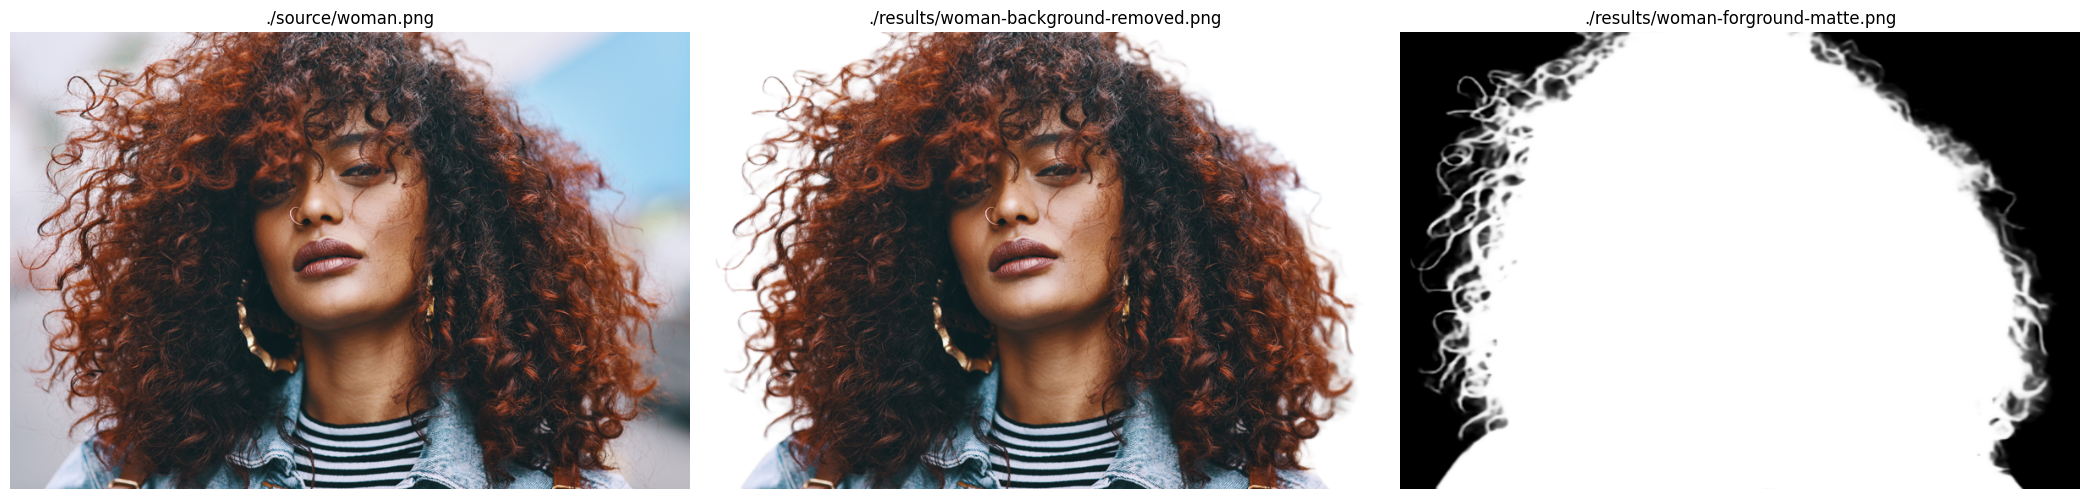

In [27]:
source_img = './source/woman.png'
removed_background_file = './results/woman-background-removed.png'
foreground_matte_file = './results/woman-forground-matte.png'

remove_background(source_file=source_img,
                  removed_background_file= removed_background_file,
                  foreground_matte_file= foreground_matte_file
                  )

images = [source_img, removed_background_file, foreground_matte_file]
show_images(images=images, cols=3, source='local')

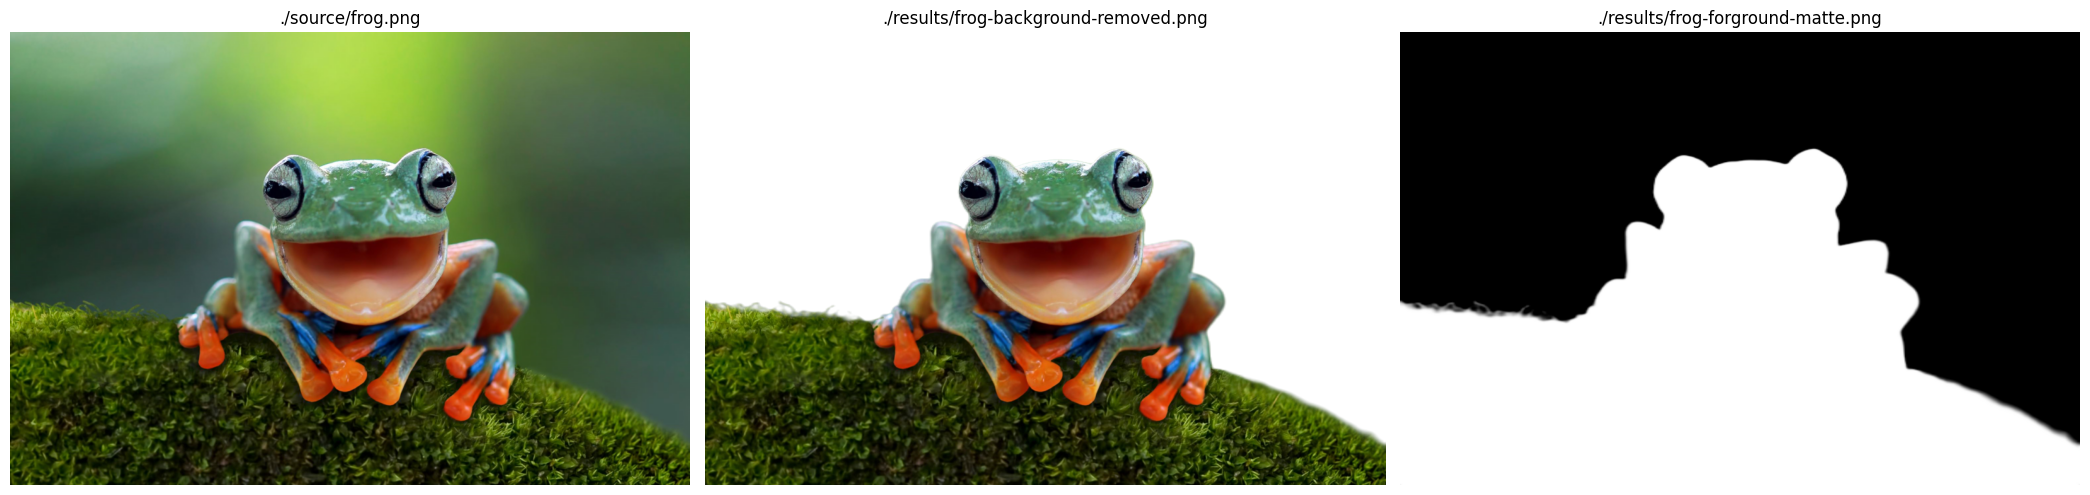

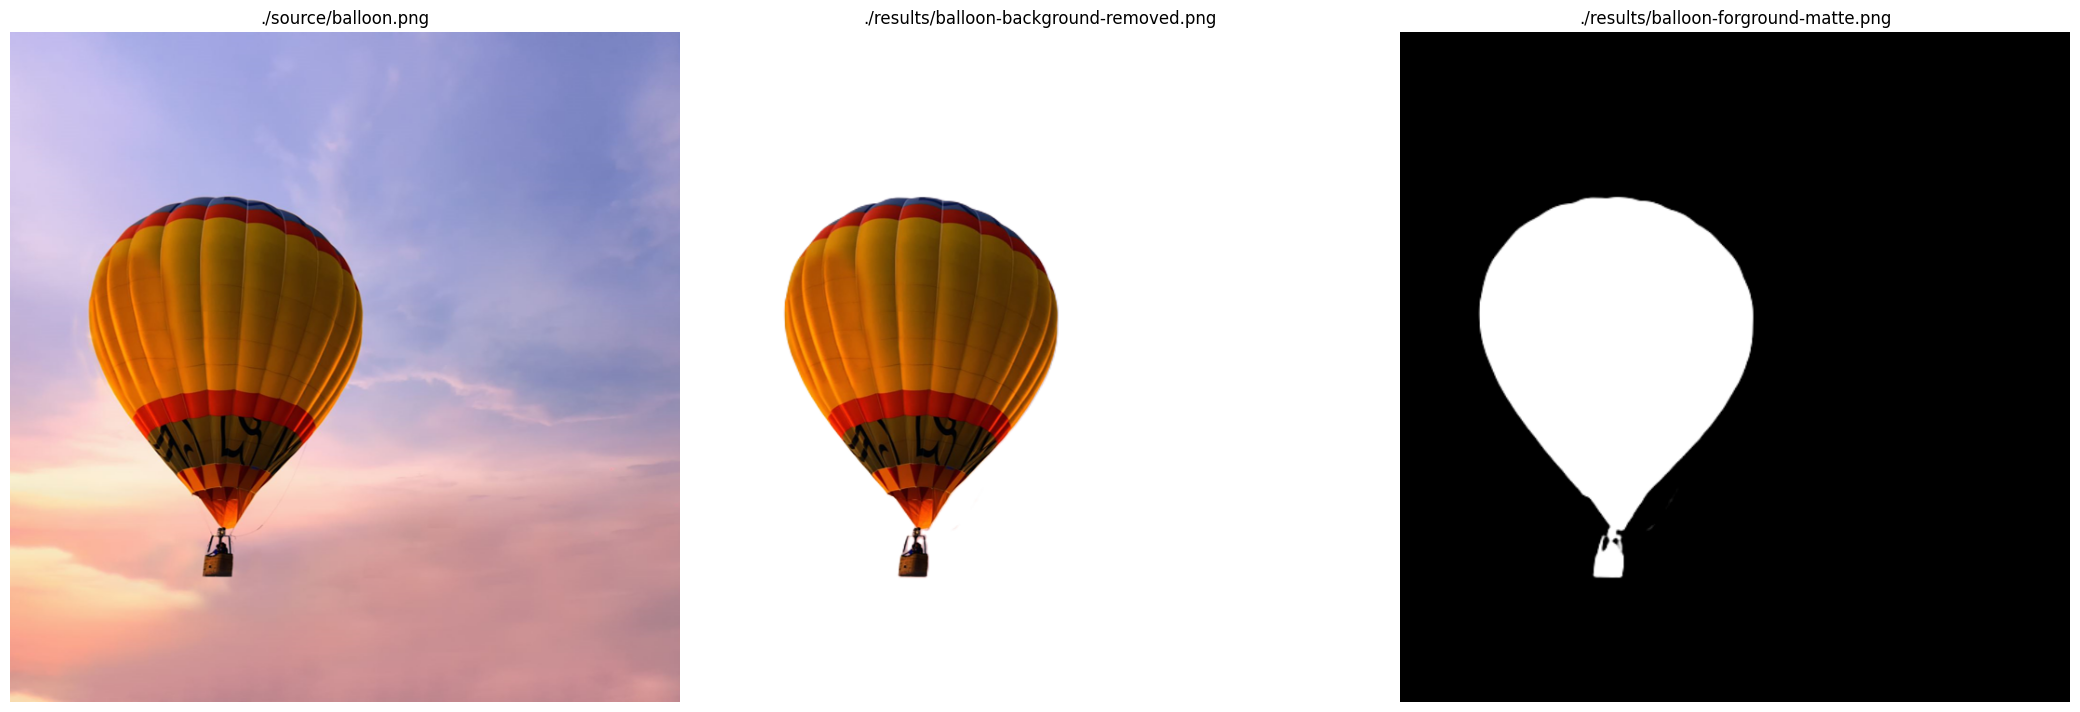

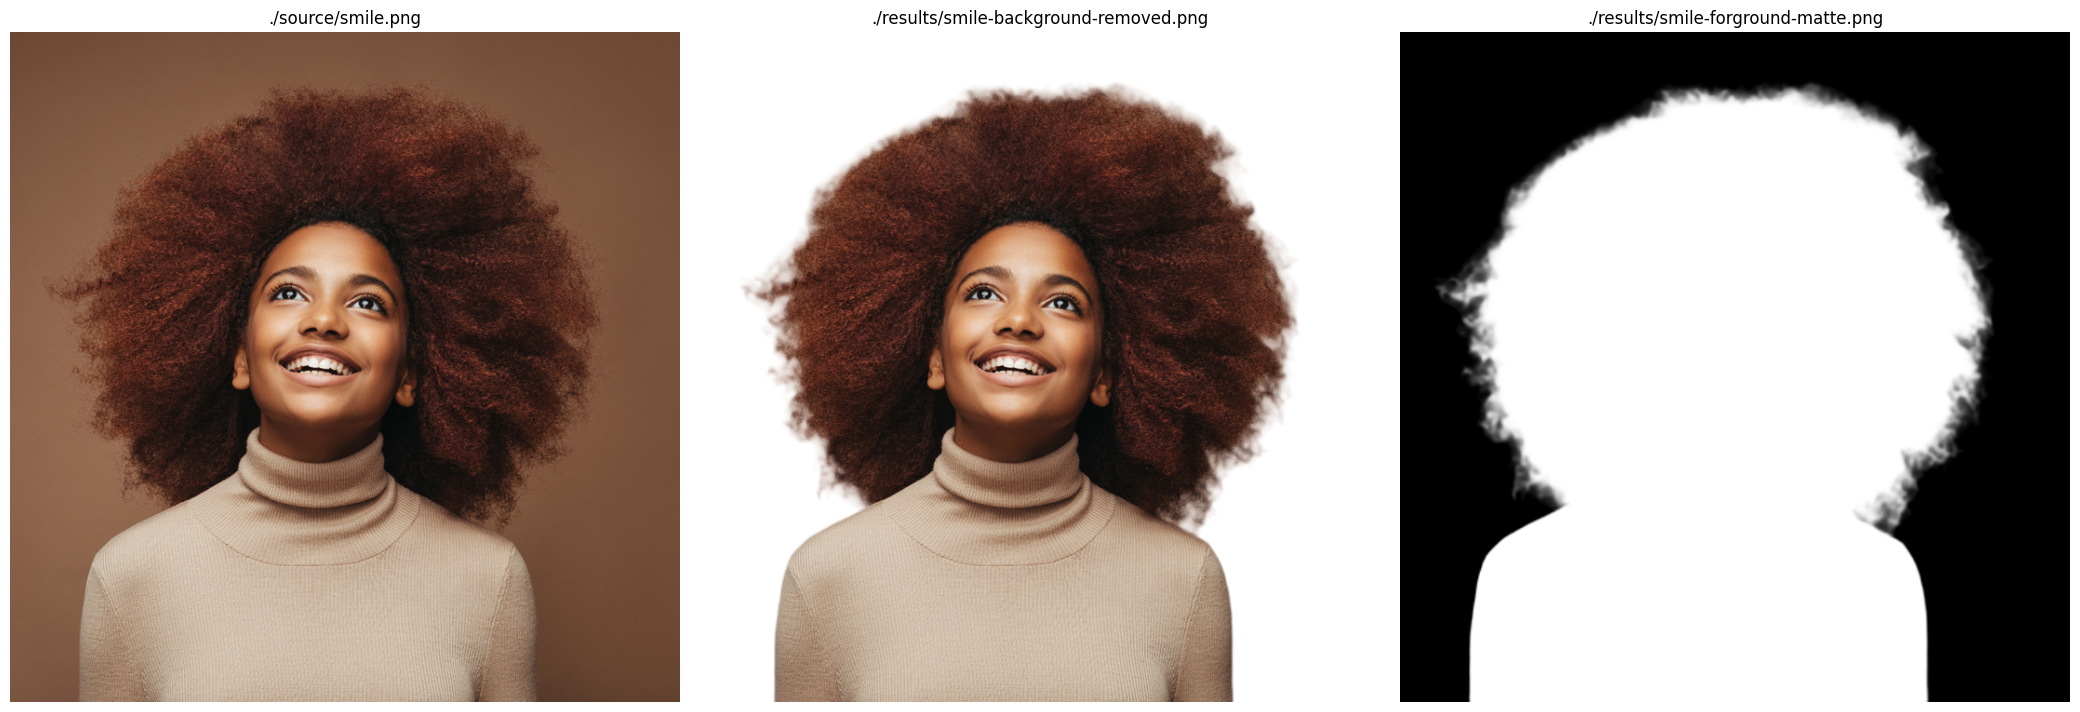

In [29]:
samples = ['frog', 'balloon', 'smile']

for sample in samples:

    source_img = f'./source/{sample}.png'
    removed_background_file = f'./results/{sample}-background-removed.png'
    foreground_matte_file = f'./results/{sample}-forground-matte.png'

    remove_background(source_file=source_img,
                    removed_background_file= removed_background_file,
                    foreground_matte_file= foreground_matte_file
                    )

    images = [source_img, removed_background_file, foreground_matte_file]
    show_images(images=images, cols=3, source='local')
